# 第二章   End-to-end Machine Learning 

## 0. 基础配置

In [53]:
# 只支持python3

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "02_end_to_end"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# 保存图片的函数
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 1. 获取数据

In [9]:
import os
import tarfile
from six.moves import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    #urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [10]:
fetch_housing_data()

In [11]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [12]:
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [13]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [14]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [15]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


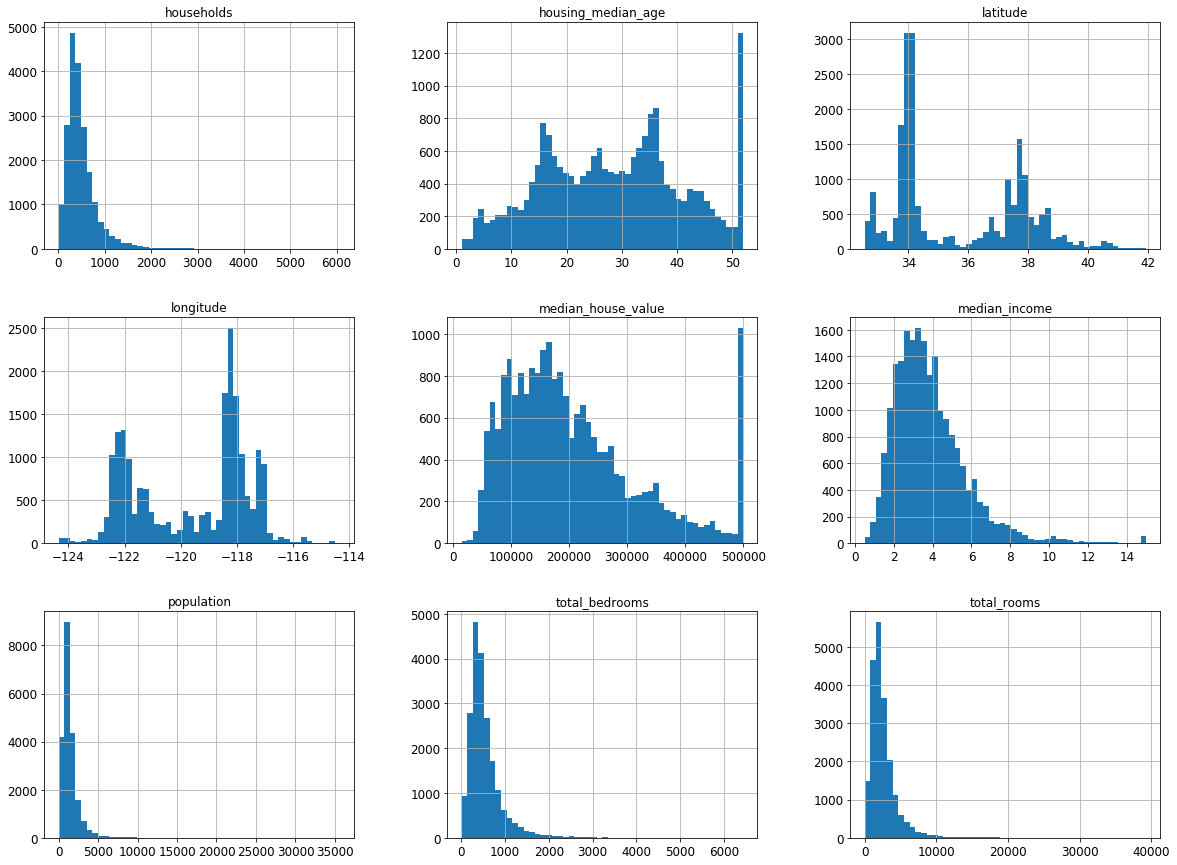

In [16]:
housing.hist(bins=50, figsize=(20,15))
plt.show()


In [17]:
# 划分训练数据和测试数据
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [18]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [19]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [21]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [22]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [23]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [24]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [25]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


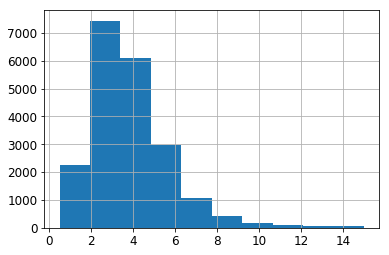

In [26]:
housing["median_income"].hist()

In [28]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [29]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

用StratifiedShuffleSplit分层采样

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [37]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

分层采样和随机采样的对比

In [39]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [40]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


我们用了大量时间来生成测试集的原因是：测试集通常被忽略，但实际是机器学习非常重要的一部分。还有，生成测试集过程中的许多思路对于后面的交叉验证讨论是非常有帮助的。接

## 2 数据探索和可视化、发现规律

### 2.1 地理位置

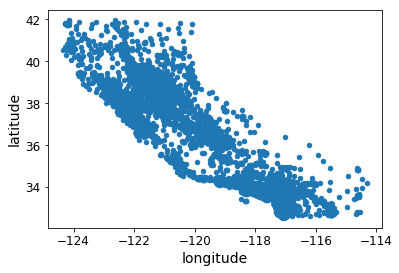

In [56]:
housing.plot(kind="scatter", x="longitude", y="latitude") #经纬度的散点图

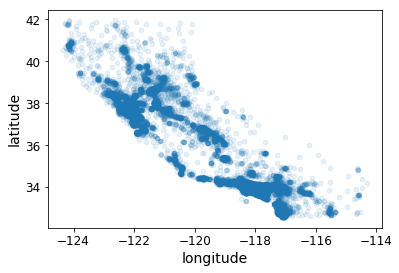

In [57]:
#上面的图看不出什么规律，将alpha设置为0.1
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
#可以非常清楚地看到高密度区域

Saving figure housing_prices_scatterplot


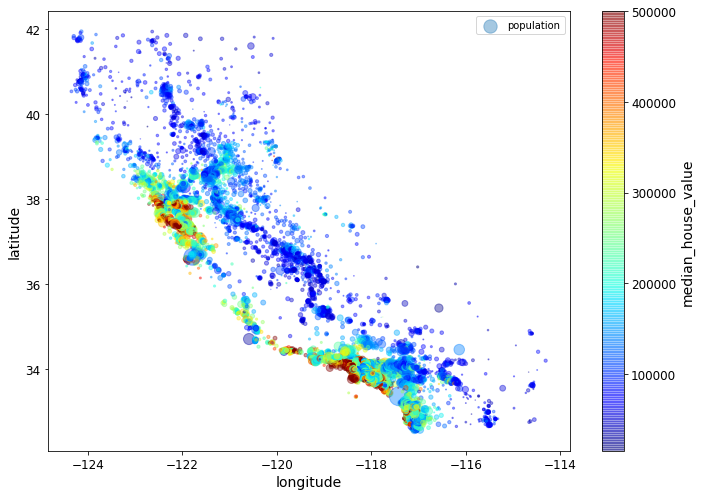

In [58]:
# 每个圈的半径表示街区的人口（选项s），颜色代表价格（选项c）。
# 我们用预先定义的名为jet的颜色图（选项cmap），它的范围是从蓝色（低价）到红色（高价）
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population",figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")
# 这张图说明房价和位置（比如，靠海）和人口密度联系密切，这点你可能早就知道。
# 可以使用聚类算法来检测主要的聚集，用一个新的特征值测量聚集中心的距离。
# 尽管北加州海岸区域的房价不是非常高，但离大海距离属性也可能很有用，所以这不是用一个简单的规则就可以定义的问题。


Saving figure california_housing_prices_plot


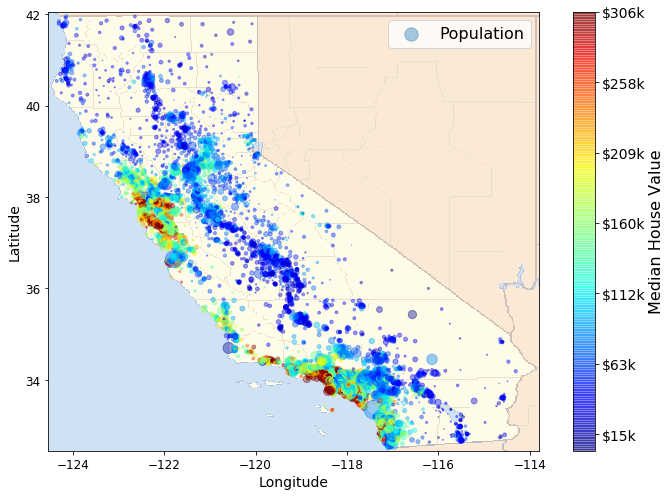

In [59]:
# 在上面的基础上将california.png作为背景
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/02_end_to_end/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

###  2.2 查找关联
因为数据集并不是非常大，你可以很容易地使用corr()方法计算出每对属性间的标准相关系数（standard correlation coefficient，也称作皮尔逊相关系数）：


In [60]:
corr_matrix = housing.corr()

In [62]:
corr_matrix["median_house_value"].sort_values(ascending=False)
# 相关系数的范围是 -1 到 1。当接近 1 时，意味强正相关；例如，当收入中位数增加时，房价中位数也会增加。
# 当相关系数接近 -1 时，意味强负相关；你可以看到，纬度和房价中位数有轻微的负相关性（即，越往北，房价越可能降低）。
# 最后，相关系数接近 0，意味没有线性相关性

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

另一种检测属性间相关系数的方法是使用 Pandas 的scatter_matrix函数，它能画出每个数值属性对每个其它数值属性的图。因为现在共有 11 个数值属性，你可以得到11 ** 2 = 121张图，在一页上画不下，所以只关注几个和房价中位数最有可能相关的属性

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ff3e630>,
      dtype=object)

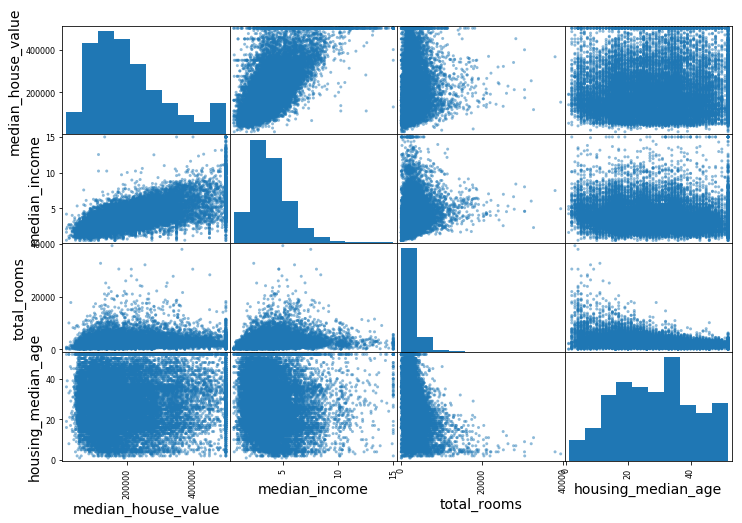

In [66]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))


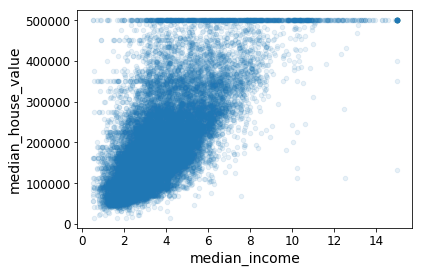

In [67]:
# 最有希望用来预测房价中位数的属性是收入中位数，因此将这张图放大
housing.plot(kind="scatter", x="median_income",y="median_house_value",
             alpha=0.1)


首先，相关性非常高；可以清晰地看到向上的趋势，并且数据点不是非常分散。第二，我们之前看到的最高价，清晰地呈现为一条位于 500000 美元的水平线。这张图也呈现了一些不是那么明显的直线：一条位于 450000 美元的直线，一条位于 350000 美元的直线，一条在 280000 美元的线，和一些更靠下的线。你可能希望去除对应的街区，以防止算法重复这些巧合

### 2.3 属性组合试验
希望前面的一节能教给你一些探索数据、发现规律的方法。你发现了一些数据的巧合，需要在给算法提供数据之前，将其去除。你还发现了一些属性间有趣的关联，特别是目标属性。你还注意到一些属性具有长尾分布，因此你可能要将其进行转换（例如，计算其log对数）。当然，不同项目的处理方法各不相同，但大体思路是相似的。

给算法准备数据之前，你需要做的最后一件事是尝试多种属性组合。例如，如果你不知道某个街区有多少户，该街区的总房间数就没什么用。你真正需要的是每户有几个房间。相似的，总卧室数也不重要：你可能需要将其与房间数进行比较。每户的人口数也是一个有趣的属性组合。让我们来创建这些新的属性：

In [68]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [69]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

与总房间数或卧室数相比，新的bedrooms_per_room属性与房价中位数的关联更强。显然，卧室数/总房间数的比例越低，房价就越高。每户的房间数也比街区的总房间数的更有信息，很明显，房屋越大，房价就越高。

这一步的数据探索不必非常完备，此处的目的是有一个正确的开始，快速发现规律，以得到一个合理的原型。但是这是一个交互过程：一旦你得到了一个原型，并运行起来，你就可以分析它的输出，进而发现更多的规律，然后再回到数据探索这步。

## 3 为机器学习算法准备数据
现在来为机器学习算法准备数据。不要手工来做，你需要写一些函数，理由如下：
- 函数可以让你在任何数据集上（比如，你下一次获取的是一个新的数据集）方便地进行重复数据转换。
- 你能慢慢建立一个转换函数库，可以在未来的项目中复用。
- 在将数据传给算法之前，你可以在实时系统中使用这些函数。
- 这可以让你方便地尝试多种数据转换，查看哪些转换方法结合起来效果最好。

In [71]:
# drop()创建了一份数据的备份，而不影响strat_train_set
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### 3.1 数据清洗
大多机器学习算法不能处理缺失的特征，因此先创建一些函数来处理特征缺失的问题。前面，你应该注意到了属性total_bedrooms有一些缺失值。有三个解决选项：
- 去掉对应的街区；
- 去掉整个属性；
- 进行赋值（0、平均值、中位数等等）

In [77]:
# Scikit-Learn 提供了一个方便的类来处理缺失值：Imputer。
# 下面是其使用方法：首先，需要创建一个Imputer实例，指定用某属性的中位数来替换该属性所有的缺失值：
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy="median")

In [78]:
# 因为只有数值属性才能算出中位数，我们需要创建一份不包括文本属性ocean_proximity的数据副本：
housing_num = housing.drop("ocean_proximity", axis=1)

In [79]:
# 现在，就可以用fit()方法将imputer实例拟合到训练数据：
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [82]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

imputer计算出了每个属性的中位数，并将结果保存在了实例变量statistics_中。虽然此时只有属性total_bedrooms存在缺失值，但我们不能确定在以后的新的数据中会不会有其他属性也存在缺失值，所以安全的做法是将imputer应用到每个数值

In [83]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [84]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [85]:
# 使用这个“训练过的”imputer来对训练集进行转换，将缺失值替换为中位数
X = imputer.transform(housing_num)

In [86]:
# 结果是含转换后特征的普通的 Numpy 数组。将其放回到 PandasDataFrame中
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### 3.2 处理文本和类别属性
前面，我们丢弃了类别属性ocean_proximity，因为它是一个文本属性，不能计算出中位数。大多数机器学习算法更喜欢和数字打交道，所以让我们把这些文本标签转换为数字。

In [87]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [89]:
# 可以查看映射表，编码器是通过属性classes_来学习的（<1H OCEAN被映射为 0，INLAND被映射为 1，等等）
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

这种做法的问题是，ML 算法会认为两个临近的值比两个疏远的值要更相似。显然这样不对（比如，分类 0 和分类 4 就比分类 0 和分类 1 更相似）。要解决这个问题，一个常见的方法是给每个分类创建一个二元属性：当分类是<1H OCEAN，该属性为 1（否则为 0），当分类是INLAND，另一个属性等于 1（否则为 0），以此类推。这称作独热编码（One-Hot Encoding），因为只有一个属性会等于 1（热），其余会是 0（冷）。

In [93]:
housing_cat[:10]

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [134]:
from future_encoders import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot=encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [135]:
import sklearn
sklearn.__version__

'0.20.3'

In [136]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [139]:
# 使用类LabelBinarizer，我们可以用一步执行这两个转换（从文本分类到整数分类，再从整数分类到独热向量）：
from sklearn.preprocessing import LabelBinarizer # just to raise an ImportError if Scikit-Learn < 0.20
encoder= LabelBinarizer(sparse_output=True)
housing_cat_1hot=encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int64'>'
	with 16512 stored elements in Compressed Sparse Row format>

### 3.3 自定义转换器
尽管 Scikit-Learn 提供了许多有用的转换器，你还是需要自己动手写转换器执行任务，比如自定义的清理操作，或属性组合

In [107]:
from sklearn.base import BaseEstimator,TransformerMixin
rooms_ix,bedrooms_ix,population_ix,household_ix=3,4,5,6
class CombineAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room=add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household=X[:,rooms_ix]/X[:,household_ix]
        population_per_household=X[:,population_ix]/X[:,household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room=X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]
attr_adder=CombineAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs=attr_adder.transform(housing.values)
    

### 3.4 特征缩放
除了个别情况，当输入的数值属性量度不同时，机器学习算法的性能都不会好。这个规律也适用于房产数据：总房间数分布范围是 6 到 39320，而收入中位数只分布在 0 到 15。注意通常情况下我们不需要对目标值进行缩放。  
有两种常见的方法可以让所有的属性有相同的量度：线性函数归一化（Min-Max scaling）和标准化（standardization）。  
- 线性归一化：值被转变重新缩放，直到范围变成0到1。减去最小值然后除以最大值与最小值的差值，sklearn提供一个转换器MinMaxScaler
- 标准化：减去平均值然后除以方差，不会限定值到具体范围，对某些算法可能构成问题，但是标准化受异常值的影响很小，sklearn提供一个转换器StandardScale


### 3.5 转换流水线
sklearn提供类Pipeline进行一些列的转换

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('imputer',  SimpleImputer(strategy="median")),
    ('attribs_adder',CombineAttributesAdder()),
    ('std_scaler',StandardScaler()),
])
housing_num_tr=num_pipeline.fit_transform(housing_num)

In [110]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

pipeline构造器需要一个定义步骤顺序的名字/估计器对的列表。除了最后一个估计器，其余都要是转换器（即它们都要有fit_transform()方法）
如果不需要手动将PandasDataFrame中的数值列转成Numpy数组的格式，而可以直接将DataFrame输入pipeline中进行处理就好了。Scikit-Learn 没有工具来处理 PandasDataFrame，因此我们需要写一个简单的自定义转换器来做这项工作：

In [111]:
from sklearn.base import BaseEstimator,TransformerMixin
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names=attribute_names
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values

每个子流水线都以一个选择转换器开始：通过选择对应的属性（数值或分类）、丢弃其它的，来转换数据，并将输出DataFrame转变成一个 NumPy 数组。这样，你就可以很简单的写出一个以PandasDataFrame为输入并且可以处理数值的流水线： 该流水线从DataFrameSelector开始获取数值属性，前面讨论过的其他数据处理步骤紧随其后。 并且你也可以通过使用DataFrameSelector选择类别属性并为其写另一个流水线然后应用LabelBinarizer.
你现在就有了一个对数值的流水线，你还需要对分类值应用LabelBinarizer：如何将这些转换写成一个流水线呢？Scikit-Learn 提供了一个类FeatureUnion实现这个功能。你给它一列转换器（可以是所有的转换器），当调用它的transform()方法，每个转换器的transform()会被并行执行，等待输出，然后将输出合并起来，并返回结果（当然，调用它的fit()方法就会调用每个转换器的fit()）。一个完整的处理数值和类别属性的流水线如下所示：

In [144]:
from sklearn.pipeline import FeatureUnion
num_attribs=list(housing_num)
cat_attribs=["ocean_proximity"]
num_pipeline=Pipeline([
    ('selector',DataFrameSelector(num_attribs)),
    ('imputer',SimpleImputer(strategy="median")),
    ('attribs_adder',CombineAttributesAdder()),
    ('std_scaler',StandardScaler()),
])
cat_pipeline=Pipeline([
    ('selector',DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])
full_pipeline=FeatureUnion(transformer_list=[
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline),
])

In [145]:
housing_prepared=full_pipeline.fit_transform(housing)
housing_prepared


array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## 4 选择并训练模型
前面限定了问题、获得了数据、探索了数据、采样了一个测试集、写了自动化的转换流水线来清理和为算法准备数据。现在，你已经准备好选择并训练一个机器学习模型了

### 4.1 在训练集上训练和评估

In [156]:
# 线性回归模型
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)
print(housing_prepared.shape)
print(housing_labels.shape)

(16512, 17)
(16512,)


In [166]:
# 预测对比
some_data=housing.iloc[:5]
some_labels=housing_labels.iloc[:5]
some_data_prepared=full_pipeline.transform(some_data)
print(lin_reg.predict(some_data_prepared))
print(list(some_labels))

[203682.37379543 326371.39370781 204218.64588245  58685.4770482
 194213.06443039]
[286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [167]:
# MSE 均方差
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68376.64295459937

但显然结果并不好：大多数街区的median_housing_values位于 120000 到 265000 美元之间，因此预测误差 68628 美元不能让人满意  
这是一个模型欠拟合训练数据的例子。当这种情况发生时，意味着特征没有提供足够多的信息来做出一个好的预测，或者模型并不强大。就像前一章看到的，修复欠拟合的主要方法是选择一个更强大的模型，给训练算法提供更好的特征，或去掉模型上的限制。这个模型还没有正则化，所以排除了最后一个选项。你可以尝试添加更多特征（比如，人口的对数值），但是首先让我们尝试一个更为复杂的模型，看看效果。

In [168]:
# DecisionTreeRegressor。这是一个强大的模型，可以发现数据中复杂的非线性关系
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [169]:
housing_predictions=tree_reg.predict(housing_prepared)
tree_mse=mean_squared_error(housing_labels,housing_predictions)
tree_rmse=np.sqrt(tree_mse)
tree_mse

0.0

模型严重过拟合数据

### 4.2 使用交叉验证做更佳评估
评估决策树模型的一种方法是用函数train_test_split来分割训练集，得到一个更小的训练集和一个验证集，然后用更小的训练集来训练模型，用验证集来评估。这需要一定工作量，并不难而且也可行。

另一种更好的方法是使用 Scikit-Learn 的交叉验证功能。下面的代码采用了 K 折交叉验证（K-fold cross-validation）：它随机地将训练集分成十个不同的子集，成为“折”，然后训练评估决策树模型 10 次，每次选一个不用的折来做评估，用其它 9 个来做训练。结果是一个包含 10 个评分的数组

In [176]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(tree_reg,housing_prepared,housing_labels,
scoring='neg_mean_squared_error',cv=10)
tree_rmse_scores=np.sqrt(-scores)

In [178]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)

Scores: [69527.15275267 67126.33533817 71007.25248043 68376.75003099
 71394.61979871 74419.88513084 71664.39569675 71160.15193335
 76053.41863487 70278.68947692]
Mean: 71100.86512737114
Standard deviation: 2496.5986928760003


现在决策树就不像前面看起来那么好了。实际上，它看起来比线性回归模型还糟！注意到交叉验证不仅可以让你得到模型性能的评估，还能测量评估的准确性（即，它的标准差）。决策树的评分大约是 71200，通常波动有 ±3200。如果只有一个验证集，就得不到这些信息。但是交叉验证的代价是训练了模型多次，不可能总是这样。

In [182]:
# 线性回归
lin_scores=cross_val_score(lin_reg,housing_prepared,housing_labels,
scoring='neg_mean_squared_error',cv=10)
lin_rmse_scores=np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [51848.29564266 49161.01149152 52224.35929834 55052.45150736
 52575.94833525 56038.31505013 50758.15410221 50486.13443161
 55586.90228603 53511.65993516]
Mean: 52724.32320802791
Standard deviation: 2186.9815970200084


现在再尝试最后一个模型：RandomForestRegressor。第7章我们会看到，随机森林是通过用特征的随机子集训练许多决策树。在其它多个模型之上建立模型称为集成学习（Ensemble Learning），它是推进 ML 算法的一种好方法。我们会跳过大部分的代码，因为代码本质上和其它模型一样：

In [183]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)
housing_predictions=forest_reg.predict(housing_prepared)
forest_mse=mean_squared_error(housing_labels,housing_predictions)
forest_rmse=np.sqrt(forest_mse)
print('forest_rmse=',forest_rmse)
scores=cross_val_score(forest_reg,housing_prepared,housing_labels,
scoring='neg_mean_squared_error',cv=10)
forest_rmse_scores=np.sqrt(-scores)
display_scores(forest_rmse_scores)

/Users/yangzhan/Desktop/handson-ml-cn/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


forest_rmse= 22442.991150131875
Scores: [51632.11871771 50565.23509781 52423.77612583 55094.47857249
 51660.17817516 55455.08975802 50490.42971799 49747.76278183
 55175.33304407 52440.77511916]
Mean: 52468.51771100787
Standard deviation: 1985.8424918876087


在好多了：随机森林看起来很有希望。但是，训练集的评分仍然比验证集的评分低很多。解决过拟合可以通过简化模型，给模型加限制（即，规整化），或用更多的训练数据。在深入随机森林之前，你应该尝试下机器学习算法的其它类型模型（不同核心的支持向量机，神经网络，等等），不要在调节超参数上花费太多时间。目标是列出一个可能模型的列表（两到五个）。

## 5 模型微调

### 5.1 网格搜索
微调的一种方法是手工调整超参数，直到找到一个好的超参数组合。这么做的话会非常冗长，你也可能没有时间探索多种组合。

你应该使用 Scikit-Learn 的GridSearchCV来做这项搜索工作。你所需要做的是告诉GridSearchCV要试验有哪些超参数，要试验什么值，GridSearchCV就能用交叉验证试验所有可能超参数值的组合。例如，下面的代码搜索了RandomForestRegressor超参数值的最佳组合：

In [184]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'n_estimators': [3, 10], 'bootstrap': [False], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [185]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [186]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [188]:
cvres=grid_search.cv_results_
for mean_score,params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)

65343.21417802151 {'n_estimators': 3, 'max_features': 2}
56146.829424609845 {'n_estimators': 10, 'max_features': 2}
53104.80722300334 {'n_estimators': 30, 'max_features': 2}
61430.64717617027 {'n_estimators': 3, 'max_features': 4}
53994.92364065411 {'n_estimators': 10, 'max_features': 4}
51468.90390306528 {'n_estimators': 30, 'max_features': 4}
59599.609176615486 {'n_estimators': 3, 'max_features': 6}
53256.81843322112 {'n_estimators': 10, 'max_features': 6}
50993.93409572003 {'n_estimators': 30, 'max_features': 6}
59246.75773441062 {'n_estimators': 3, 'max_features': 8}
53119.16299197545 {'n_estimators': 10, 'max_features': 8}
50815.38714173116 {'n_estimators': 30, 'max_features': 8}
62326.7475673941 {'n_estimators': 3, 'bootstrap': False, 'max_features': 2}
54688.61136981717 {'n_estimators': 10, 'bootstrap': False, 'max_features': 2}
61166.74525524564 {'n_estimators': 3, 'bootstrap': False, 'max_features': 3}
53325.73972661166 {'n_estimators': 10, 'bootstrap': False, 'max_features': 

### 5.2 随机搜索
当探索相对较少的组合时，就像前面的例子，网格搜索还可以。但是当超参数的搜索空间很大时，最好使用RandomizedSearchCV。这个类的使用方法和类GridSearchCV很相似，但它不是尝试所有可能的组合，而是通过选择每个超参数的一个随机值的特定数量的随机组合。这个方法有两个优点：

- 如果你让随机搜索运行，比如 1000 次，它会探索每个超参数的 1000 个不同的值（而不是像网格搜索那样，只搜索每个超参数的几个值）。

- 你可以方便地通过设定搜索次数，控制超参数搜索的计算量。

In [189]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distrbs={
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
}
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg,param_distributions=param_distrbs,
                               n_iter=10,cv=5,scoring="neg_mean_squared_error",
                               random_state=42)
rnd_search.fit(housing_prepared,housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1389aeb70>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1397d0080>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [190]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49931.83370450304 {'n_estimators': 180, 'max_features': 7}
52122.26073885765 {'n_estimators': 15, 'max_features': 5}
51463.906813209505 {'n_estimators': 72, 'max_features': 3}
51381.385870076425 {'n_estimators': 21, 'max_features': 5}
50040.63743808166 {'n_estimators': 122, 'max_features': 7}
51436.763292635806 {'n_estimators': 75, 'max_features': 3}
51286.345451957626 {'n_estimators': 88, 'max_features': 3}
50312.57595748435 {'n_estimators': 100, 'max_features': 5}
50995.415279184126 {'n_estimators': 150, 'max_features': 3}
65455.38356204712 {'n_estimators': 2, 'max_features': 5}


### 5.3 分析最佳模型和它们的误差
通过分析最佳模型，常常可以获得对问题更深的了解。比如，RandomForestRegressor可以指出每个属性对于做出准确预测的相对重要性：


In [192]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.32538761e-02, 6.09975470e-02, 4.44363450e-02, 1.58085734e-02,
       1.57569854e-02, 1.51039733e-02, 1.53121227e-02, 2.69476340e-01,
       1.72632999e-01, 3.44967601e-02, 1.07409174e-01, 3.93365487e-02,
       3.60918515e-03, 1.36351794e-01, 9.99893646e-05, 2.65602147e-03,
       3.26176434e-03])

In [195]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs=list(encoder.classes_)
attributes = num_attribs+extra_attribs+cat_one_hot_attribs
sorted(zip(feature_importances,attributes),reverse=True)

[(0.2694763404021859, 'median_income'),
 (0.17263299932479212, 'income_cat'),
 (0.13635179416592663, 'INLAND'),
 (0.10740917397501867, 'pop_per_hhold'),
 (0.06325387608907705, 'longitude'),
 (0.06099754702772913, 'latitude'),
 (0.0444363450483898, 'housing_median_age'),
 (0.03933654865273722, 'bedrooms_per_room'),
 (0.03449676014706798, 'rooms_per_hhold'),
 (0.015808573420415074, 'total_rooms'),
 (0.015756985437997844, 'total_bedrooms'),
 (0.015312122672532406, 'households'),
 (0.015103973308661226, 'population'),
 (0.003609185152218552, '<1H OCEAN'),
 (0.0032617643377805218, 'NEAR OCEAN'),
 (0.002656021472917555, 'NEAR BAY'),
 (9.998936455231693e-05, 'ISLAND')]

### 5.4 用测试集评估系统
调节完系统之后，你终于有了一个性能足够好的系统。现在就可以用测试集评估最后的模型了。这个过程没有什么特殊的：从测试集得到预测值和标签，运行full_pipeline转换数据（调用transform()，而不是fit_transform()！），再用测试集评估最终模型：

In [197]:
final_model = grid_search.best_estimator_
X_test=strat_test_set.drop("median_house_value",axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions=final_model.predict(X_test_prepared)
final_mse=mean_squared_error(y_test,final_predictions)
final_rmse = np.sqrt(final_mse)

In [198]:
final_rmse

48411.841669624526

## 6 启动，监控，维护系统
很好，你被允许启动系统了！你需要为实际生产做好准备，特别是接入输入数据源，并编写测试。

你还需要编写监控代码，以固定间隔检测系统的实时表现，当发生下降时触发报警。这对于捕获突然的系统崩溃和性能下降十分重要。做监控很常见，是因为模型会随着数据的演化而性能下降，除非模型用新数据定期训练。

评估系统的表现需要对预测值采样并进行评估。这通常需要人来分析。分析者可能是领域专家，或者是众包平台（比如 Amazon Mechanical Turk 或 CrowdFlower）的工人。不管采用哪种方法，你都需要将人工评估的流水线植入系统。

你还要评估系统输入数据的质量。有时因为低质量的信号（比如失灵的传感器发送随机值，或另一个团队的输出停滞），系统的表现会逐渐变差，但可能需要一段时间，系统的表现才能下降到一定程度，触发警报。如果监测了系统的输入，你就可能尽量早的发现问题。对于线上学习系统，监测输入数据是非常重要的。

最后，你可能想定期用新数据训练模型。你应该尽可能自动化这个过程。如果不这么做，非常有可能你需要每隔至少六个月更新模型，系统的表现就会产生严重波动。如果你的系统是一个线上学习系统，你需要定期保存系统状态快照，好能方便地回滚到之前的工作状态。



## 练习

In [205]:
# 1. 尝试支持向量机回归器
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
param_grid = [
        {'kernel': ['linear'], 'C': [10., 100., 1000.]},
        {'kernel': ['rbf'], 'C': [1.0, 10, 100., 1000.0],
         'gamma': [0.01, 0.1]},
    ]
svm_reg=SVR()
grid_search=GridSearchCV(svm_reg,param_grid,cv=5,scoring='neg_mean_squared_error',verbose=2,n_jobs=2)
grid_search.fit(housing_prepared,housing_labels)


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done  55 out of  55 | elapsed:  6.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid=[{'kernel': ['linear'], 'C': [10.0, 100.0, 1000.0]}, {'kernel': ['rbf'], 'C': [1.0, 10, 100.0, 1000.0], 'gamma': [0.01, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [206]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

49931.83370450304

In [201]:
# 2. 尝试在准备流水线中添加一个只选择最重要属性的转换器。

In [202]:
# 3.尝试创建一个单独的可以完成数据准备和最终预测的流水线。